# Synthetic Product Data Generation for E-commerce Newsletters

**Objective:** This notebook generates synthetic product data for three e-commerce stores (Konvy, Uniqlo, Gramedia) using the Google Generative AI SDK (Gemini API). The generated data will mimic the structure of previously extracted newsletter metadata, with an added `product_description` field. This synthetic dataset can be used for developing and testing recommender systems or other data-driven applications.

**Steps:**
1.  **Setup & Configuration:** Import libraries, load API keys, configure the Google Generative AI SDK, and define file paths and generation parameters.
2.  **Schema Definition:** Define the target JSON schema for the synthetic product data.
3.  **Store-Specific Prompts:** Create detailed prompts for each store, outlining product types, language, currency, and other characteristics to guide the Gemini model.
4.  **Gemini API Interaction for Data Generation:** Define a function to send prompts to the Gemini API and request structured JSON output containing synthetic product data.
5.  **Main Data Generation Loop:** Orchestrate the generation process for each store.
6.  **Execution & Results:** Run the generation, compile the data into a Pandas DataFrame, display it, and save it to a CSV file.

**Prerequisites:**
- Ensure you have the `google-generativeai`, `pandas`, and `python-dotenv` libraries installed:
  `pip install google-generativeai pandas python-dotenv`
- A `.env` file in the project root containing your `GEMINI_API_KEY`.
- The project directory structure should allow saving the output to `data/processed/`.

In [13]:
import os
import json
import pandas as pd
from dotenv import load_dotenv
import asyncio
import time # For adding delays

# For running async code in Jupyter environments smoothly
import nest_asyncio
nest_asyncio.apply()

# Google Generative AI SDK
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold # For safety settings
from google.api_core import exceptions as google_api_exceptions # For specific API errors

# For Embeddings and Visualization
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Informational check for environment (less critical for SDK than direct fetch)
try:
    from js import fetch 
    IS_CANVAS_ENV = True
    print("Running in a Canvas-like (Pyodide/JavaScript) environment.")
except ImportError:
    IS_CANVAS_ENV = False
    print("Not running in a Canvas-like environment (standard Python execution).")

Not running in a Canvas-like environment (standard Python execution).


## 2. Configuration

Set up essential configuration variables:
-   **API Key:** Loaded from `.env` and used for the Google Generative AI SDK.
-   **Project Root and Paths:** Define project structure for accessing `.env` and saving output.
-   **Generation Parameters:** Number of items per store, API call delays, and retries.

In [23]:
# --- API Key Loading ---
def load_api_key(project_r):
    """Loads the Gemini API key from the .env file located in the project root."""
    env_path = os.path.join(project_r, '.env')
    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        print(f".env file loaded from: {env_path}")
    else:
        # Fallback for cases where .env might be in current dir (e.g. running script from project root)
        load_dotenv()
        if os.path.exists(".env"):
             print(f".env file loaded from current directory: {os.getcwd()}/.env")
        else:
            print(f"Warning: .env file not found at {env_path} or in current directory.")

    api_key_loaded = os.getenv("GEMINI_API_KEY")
    if not api_key_loaded:
        print("Warning: GEMINI_API_KEY not found in .env file or environment variables.")
        # For non-Canvas, this is usually a critical issue.
        return None 
    print("GEMINI_API_KEY loaded.")
    return api_key_loaded

# --- Determine Project Root ---
current_working_dir = os.getcwd()
print(f"Current working directory (os.getcwd()): {current_working_dir}")
if os.path.basename(current_working_dir).lower() == "notebooks":
    PROJECT_ROOT = os.path.abspath(os.path.join(current_working_dir, ".."))
    print(f"Detected 'notebooks' subdirectory. Setting PROJECT_ROOT to: {PROJECT_ROOT}")
else:
    PROJECT_ROOT = current_working_dir 
    print(f"Not in 'notebooks' subdirectory. Assuming PROJECT_ROOT is: {PROJECT_ROOT}")

API_KEY = load_api_key(PROJECT_ROOT)

# --- Configure Google Generative AI SDK ---
SDK_CONFIGURED_SUCCESSFULLY = False
if API_KEY: 
    try:
        genai.configure(api_key=API_KEY)
        SDK_CONFIGURED_SUCCESSFULLY = True
        print("Google Generative AI SDK configured successfully.")
    except Exception as e:
        print(f"Error configuring Google Generative AI SDK with loaded API key: {e}")
else:
    print("Google Generative AI SDK not configured due to missing API key.")

# --- Directory and File Paths ---
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results") # For figures
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
RESULTS_FIGURES_DIR = os.path.join(RESULTS_DIR, "figures") # For saving plots
OUTPUT_SYNTHETIC_CSV_FILENAME = "synthetic_newsletter_product_data.csv" 
OUTPUT_SYNTHETIC_CSV_PATH = os.path.join(DATA_PROCESSED_DIR, OUTPUT_SYNTHETIC_CSV_FILENAME)
OUTPUT_EMBEDDING_PLOT_FILENAME = "product_description_embeddings_2d.png"
OUTPUT_EMBEDDING_PLOT_PATH = os.path.join(RESULTS_FIGURES_DIR, OUTPUT_EMBEDDING_PLOT_FILENAME)

# --- Generation Parameters ---
ITEMS_PER_STORE = 50
HTML_CONTENT_LIMIT_FOR_PROMPT = 1000 # Max chars of example HTML to include in prompt (if any, not used here)
API_CALL_DELAY_SECONDS = 10 # Delay between major API calls (per store)
API_MAX_RETRIES = 3        
API_RETRY_DELAY_SECONDS = 15 

# --- Embedding Parameters ---
SBERT_MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2' # Good for multilingual text

# --- Ensure directories exist ---
if not os.path.exists(DATA_PROCESSED_DIR): 
    os.makedirs(DATA_PROCESSED_DIR)
    print(f"Created directory: {DATA_PROCESSED_DIR}")
# Note: RESULTS_FIGURES_DIR creation is now also handled within the visualization function for robustness.
if not os.path.exists(RESULTS_FIGURES_DIR):
    os.makedirs(RESULTS_FIGURES_DIR)
    print(f"Created directory: {RESULTS_FIGURES_DIR}")

print(f"Final Project Root used for paths: {PROJECT_ROOT}")
print(f"Processed Data Directory used: {DATA_PROCESSED_DIR}")
print(f"Figures Directory used: {RESULTS_FIGURES_DIR}")
print(f"Output Synthetic CSV will be: {OUTPUT_SYNTHETIC_CSV_PATH}")
print(f"Output Embedding Plot will be: {OUTPUT_EMBEDDING_PLOT_PATH}")

Current working directory (os.getcwd()): /mnt/c/Users/tduricic/Development/workspace/conversational-reco/notebooks
Detected 'notebooks' subdirectory. Setting PROJECT_ROOT to: /mnt/c/Users/tduricic/Development/workspace/conversational-reco
.env file loaded from: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/.env
GEMINI_API_KEY loaded.
Google Generative AI SDK configured successfully.
Created directory: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures
Final Project Root used for paths: /mnt/c/Users/tduricic/Development/workspace/conversational-reco
Processed Data Directory used: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed
Figures Directory used: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures
Output Synthetic CSV will be: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed/synthetic_newsletter_product_data.csv
Output Embedding Plot will be: /mnt/c

## 3. Target Schema for Synthetic Data

Define the JSON schema for the synthetic product data. This schema will be used to instruct the Gemini model on the desired output format for each product. It includes fields similar to the extracted data, plus `product_description`.


In [10]:
TARGET_SCHEMA = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
        "properties": {
            # "newsletter_source" is removed from here; it's added programmatically.
            "product_name": {"type": "STRING", "description": "Name of the synthetic product. Should be realistic for the store and in the store's primary language."},
            "category": {"type": "STRING", "description": "Category of the product (e.g., 'Skincare', 'Men's T-Shirt', 'Novel', 'Comic'). Should be realistic for the store."},
            "price": {"type": "STRING", "description": "Price of the product, including the correct currency symbol (e.g., '77฿', '$29.90', 'Rp 150.000')."},
            "original_price": {"type": "STRING", "description": "An optional original price if the item is on sale (e.g., '100฿', '$39.90', 'Rp 200.000'). Use null if not on sale."},
            "discount": {"type": "STRING", "description": "Discount information if applicable (e.g., '20% off', 'Save $10', 'Special Price'). Use null if no discount."},
            "promotion_description": {"type": "STRING", "description": "A brief description of a promotion if the item is part of one (e.g., 'Weekend Flash Sale', 'New Arrivals Offer', 'Member Exclusive'). Use null if not part of a specific promotion."},
            "availability": {"type": "STRING", "description": "Availability status (e.g., 'In Stock', 'Limited Stock', 'Online Only', 'New Arrival')."},
            "product_url": {"type": "STRING", "description": "A plausible but synthetic URL for the product page (e.g., 'https://storename.com/category/product-name-slug')."},
            "image_url": {"type": "STRING", "description": "A plausible but synthetic URL for a product image (e.g., 'https://cdn.storename.com/images/product-image.jpg')."},
            "product_description": {"type": "STRING", "description": "A detailed, engaging, and realistic product description (1-3 sentences) in the store's primary language. This should highlight key features and benefits."}
        },
        "required": [
            "product_name", "category", "price", "availability", 
            "product_url", "image_url", "product_description"
        ] 
    }
}
print("Target schema for synthetic data defined (newsletter_source will be added programmatically).")

Target schema for synthetic data defined (newsletter_source will be added programmatically).


## 4. Store-Specific Prompts for Data Generation

These prompts provide detailed instructions to the Gemini model for generating synthetic data tailored to each store's characteristics (product types, language, currency, etc.).

In [5]:
KONVY_PROMPT_DETAILS = """
Store Name: Konvy
Primary Language for Product Names & Descriptions: Thai
Currency: Thai Baht (฿)
Number of Items to Generate: {num_items}

Product Focus: Beauty and personal care products.
Key Categories:
- Skincare (e.g., serums, moisturizers, sunscreens, cleansers, face masks - ครีมบำรุงผิว, เซรั่ม, กันแดด, คลีนเซอร์, มาส์กหน้า)
- Makeup (e.g., foundation, lipstick, eyeshadow palettes, mascara - รองพื้น, ลิปสติก, อายแชโดว์, มาสคาร่า)
- Haircare (e.g., shampoo, conditioner, hair treatments - แชมพู, ครีมนวดผม, ทรีทเม้นท์บำรุงผม)
- Fragrance (e.g., perfumes for men and women - น้ำหอมชาย, น้ำหอมหญิง)
- Body Care (e.g., lotions, scrubs, shower gels - โลชั่นทาผิวกาย, สครับขัดผิว, เจลอาบน้ำ)
- Beauty Tools (e.g., makeup brushes, sponges - แปรงแต่งหน้า, ฟองน้ำ)

Product Naming Style: Often includes brand names (can be international or local Thai brands - you can invent plausible brand names), product type, and key ingredients or benefits. Examples: "เซรั่มวิตามินซีเข้มข้น SOMEBYMI", "กันแดดเนื้อบางเบา MizuMi UV Water Serum SPF50+", "ลิปทินท์ติดทนนาน 4U2 Jelly Tint".
Pricing: Realistic for mid-range to slightly premium beauty products in Thailand (e.g., 100฿ - 2000฿).
Product URLs: Should follow a pattern like `https://www.konvy.com/brand_name/product-name-thai-slug-product_id.html`
Image URLs: Should follow a pattern like `https://img.konvy.com/path/to/image-product_id.jpg`
Product Descriptions (Thai): 1-3 sentences highlighting benefits, key ingredients, or usage. Make them sound appealing and typical for beauty product marketing. For example: "เซรั่มเนื้อบางเบา ซึมซาบเร็ว ช่วยลดเลือนจุดด่างดำและปรับผิวให้กระจ่างใส อุดมด้วยสารสกัดจากธรรมชาติ ปลอดภัยสำหรับผิวแพ้ง่าย" (Lightweight serum, absorbs quickly, helps reduce dark spots and brighten skin. Rich in natural extracts, safe for sensitive skin.)
Promotions: Include occasional sales (e.g., "ลด 15%", "ซื้อ 1 แถม 1"), new arrivals ("สินค้าใหม่!"), or limited offers ("จำนวนจำกัด").
Availability: Mostly "In Stock" (มีสินค้า), some "Limited Stock" (สินค้ามีจำนวนจำกัด).
"""

UNIQLO_PROMPT_DETAILS = """
Store Name: Uniqlo
Primary Language for Product Names & Descriptions: English
Currency: US Dollar ($)
Number of Items to Generate: {num_items}

Product Focus: Casual wear, basics, functional apparel (LifeWear philosophy).
Key Categories:
- Men's Clothing (T-Shirts, Polos, Shirts, Sweaters, Hoodies, Outerwear, Pants, Jeans, Shorts, Innerwear, Sport Utility Wear)
- Women's Clothing (T-Shirts, Blouses, Shirts, Sweaters, Cardigans, Hoodies, Outerwear, Dresses, Skirts, Pants, Jeans, Leggings, Innerwear, Sport Utility Wear)
- Kids' Clothing (Tops, Bottoms, Outerwear, Innerwear for various age groups)
- Baby Clothing (Bodysuits, One-pieces, Tops, Bottoms)
- Accessories (Socks, Hats, Scarves, Belts, Bags)

Product Naming Style: Often descriptive, sometimes includes collection names (e.g., AIRism, HEATTECH, Ultra Light Down, Supima Cotton). Examples: "Men's AIRism Cotton Crew Neck T-Shirt", "Women's Ultra Stretch High Rise Leggings Pants", "Kids' HEATTECH Extra Warm Long Sleeve T-Shirt".
Pricing: Realistic for affordable to mid-range casual clothing in the US (e.g., $9.90 - $149.90).
Product URLs: Should follow a pattern like `https://www.uniqlo.com/us/en/products/ITEMCODE-PRODUCT-NAME-SLUG.html` (e.g., E123456-mens-airism-tshirt.html)
Image URLs: Should follow a pattern like `https://image.uniqlo.com/UQ/ST3/us/imagesgoods/ITEMCODE/item/goods_COLORCODE_ITEMCODE.jpg`
Product Descriptions (English): 1-3 sentences focusing on material, comfort, style, or functionality. Examples: "Smooth AIRism fabric with a cotton look. Perfect for everyday wear.", "Incredibly stretchy for all-day comfort. Versatile design for any occasion.", "HEATTECH technology provides warmth without the bulk. Soft and gentle on the skin."
Promotions: Include occasional limited-time offers (e.g., "Now $19.90", "Special Offer"), new arrivals, or seasonal collections.
Availability: Mostly "In Stock", some "Online Exclusive", "New Arrival".
"""

GRAMEDIA_PROMPT_DETAILS = """
Store Name: Gramedia
Primary Language for Product Names & Descriptions: Indonesian
Currency: Indonesian Rupiah (Rp)
Number of Items to Generate: {num_items}

Product Focus: Books, stationery, office/school supplies, some lifestyle items.
Key Categories:
- Books (Fiction Novels - Novel Fiksi, Non-Fiction - Non-Fiksi, Comics - Komik, Manga, Children's Books - Buku Anak, Self-Improvement - Pengembangan Diri, Business - Bisnis & Ekonomi, Textbooks - Buku Pelajaran)
- Stationery (Notebooks - Buku Tulis, Pens - Pulpen, Pencils - Pensil, Markers - Spidol, Art Supplies - Peralatan Seni Lukis)
- Office Supplies (Printer Paper - Kertas Printer, Files & Folders - Map & Ordner, Desk Organizers - Organizer Meja)
- School Supplies (Backpacks - Tas Sekolah, Pencil Cases - Tempat Pensil, Calculators - Kalkulator)
- Magazines (Majalah - various topics)

Product Naming Style: Typically the title of the book/comic or a descriptive name for stationery. Author names are important for books. Examples: "Novel 'Bumi Manusia' karya Pramoedya Ananta Toer", "Komik Detektif Conan Vol. 99", "Buku Tulis Campus Isi 50 Lembar", "Pulpen Gel Joyko GP-265 Hitam".
Pricing: Realistic for books and stationery in Indonesia (e.g., Rp 10.000 - Rp 500.000 for books, Rp 5.000 - Rp 100.000 for stationery).
Product URLs: Should follow a pattern like `https://www.gramedia.com/products/product-name-slug-isbn-or-sku`
Image URLs: Should follow a pattern like `https://cdn.gramedia.com/uploads/items/product-image-isbn-or-sku.jpg`
Product Descriptions (Indonesian): 1-3 sentences providing a synopsis for books, or detailing features for stationery. Examples for books: "Sebuah novel epik yang menceritakan perjuangan di era kolonial. Penuh dengan intrik dan kisah cinta yang mendalam." (An epic novel about struggles in the colonial era. Full of intrigue and a deep love story.) For stationery: "Buku tulis berkualitas dengan kertas halus dan sampul menarik. Cocok untuk catatan sehari-hari." (Quality notebook with smooth paper and attractive cover. Suitable for daily notes.)
Promotions: Include discounts (e.g., "Diskon 20%", "Harga Spesial"), new releases ("Terbitan Baru"), or bundle offers ("Paket Hemat").
Availability: Mostly "Tersedia" (Available), some "Stok Terbatas" (Limited Stock), "Segera Terbit" (Coming Soon for books).
"""

store_prompts = {
    "Konvy": KONVY_PROMPT_DETAILS,
    "Uniqlo": UNIQLO_PROMPT_DETAILS,
    "Gramedia": GRAMEDIA_PROMPT_DETAILS
}

print("Store-specific prompt details defined.")

Store-specific prompt details defined.


## 5. Gemini API Interaction: `generate_synthetic_product_data`

This function sends a formatted prompt (including store-specific details and the target schema) to the Gemini API to generate a list of synthetic product entries.


In [6]:
async def generate_synthetic_product_data(store_name, prompt_details_template, num_items, schema):
    """
    Generates synthetic product data for a given store using the Gemini API.
    """
    if not SDK_CONFIGURED_SUCCESSFULLY:
        print(f"SDK not configured. Cannot generate data for {store_name}.")
        return []

    print(f"Generating {num_items} synthetic items for {store_name}...")
    
    # Format the prompt details with the number of items
    formatted_prompt_details = prompt_details_template.format(num_items=num_items)

    # Construct the main prompt for the API
    main_prompt = f"""
    You are a highly creative and realistic synthetic data generator for e-commerce.
    Your task is to generate a list of {num_items} distinct and plausible product entries for an online store based on the following characteristics and schema.

    Store Characteristics:
    {formatted_prompt_details}

    Output Schema:
    Strictly adhere to the following JSON schema for each product entry. The output MUST be a single JSON array containing {num_items} product objects.
    Do not include the 'newsletter_source' field in the generated objects; it will be added later.
    ```json
    {json.dumps(schema['items'], indent=2)}
    ```

    Instructions:
    - Ensure all product names, descriptions, categories, and other textual fields are realistic for the specified store and language.
    - Prices should be in the correct currency and typical for the store.
    - URLs should be plausible and follow the suggested patterns.
    - Product descriptions should be engaging and 1-3 sentences long, in the store's primary language.
    - Vary product details to create a diverse set of items.
    - Ensure the output is a valid JSON array of {num_items} objects.
    """

    # Safety settings (can be adjusted)
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    model = genai.GenerativeModel(
        model_name='gemini-1.5-flash-latest', # Or 'gemini-1.5-pro-latest' for potentially higher quality but slower/more expensive
        safety_settings=safety_settings
    )
    
    # Define the generation config with the schema for the array of items
    generation_config_for_array = genai.types.GenerationConfig(
        response_mime_type="application/json",
        response_schema=schema # The schema is for an ARRAY of items
    )
    
    response_text_for_error_reporting = ""

    for attempt in range(API_MAX_RETRIES):
        try:
            print(f"Attempt {attempt + 1} of {API_MAX_RETRIES} to generate data for {store_name}...")
            response = await model.generate_content_async(
                contents=[main_prompt],
                generation_config=generation_config_for_array
            )
            
            response_text_for_error_reporting = response.text
            # The response.text should directly be the JSON array string
            generated_items_array = json.loads(response_text_for_error_reporting)
            
            if not isinstance(generated_items_array, list):
                print(f"Error: Generated data for {store_name} is not a list as expected. Type: {type(generated_items_array)}")
                # Attempt to see if it's a dict with a key that holds the list (common issue)
                if isinstance(generated_items_array, dict) and len(generated_items_array) == 1:
                    key = list(generated_items_array.keys())[0]
                    if isinstance(generated_items_array[key], list):
                        print(f"Found list under key '{key}'. Using this list.")
                        generated_items_array = generated_items_array[key]
                    else:
                        raise ValueError("Generated data is a dict, but does not contain a list under its single key.")
                else:
                     raise ValueError("Generated data is not a list and not a recognized wrapped list format.")


            print(f"Successfully generated {len(generated_items_array)} items for {store_name}.")
            # Add the newsletter_source to each item
            for item in generated_items_array:
                item['newsletter_source'] = store_name # Add the source
            return generated_items_array

        except json.JSONDecodeError as e:
            print(f"JSON Decode Error for {store_name} (Attempt {attempt + 1}): {e}")
            print(f"Problematic text snippet: {response_text_for_error_reporting[:500]}...")
        except google_api_exceptions.ResourceExhausted as e:
            print(f"API Rate Limit Error for {store_name} (Attempt {attempt + 1}): {e}")
        except (genai.types.BlockedPromptException, genai.types.StopCandidateException) as e:
            print(f"Generation Error for {store_name} (Attempt {attempt + 1}): {type(e).__name__} - {e}")
            print("This error is often due to safety settings or issues with the prompt/response structure. Not retrying this specific error.")
            return [] # Do not retry these errors
        except ValueError as e: # Catch custom ValueError for list format
            print(f"Data Format Error for {store_name} (Attempt {attempt + 1}): {e}")
        except Exception as e:
            print(f"Unexpected Error for {store_name} (Attempt {attempt + 1}): {type(e).__name__} - {e}")

        if attempt < API_MAX_RETRIES - 1:
            wait_time = API_RETRY_DELAY_SECONDS * (attempt + 1) # Exponential backoff
            print(f"Retrying in {wait_time} seconds...")
            await asyncio.sleep(wait_time)
        else:
            print(f"Max retries reached for {store_name}. Failed to generate data.")
            return []
            
    return [] # Should be unreachable if loop completes, but as a fallback

## 6. Main Data Generation Loop

This section orchestrates the synthetic data generation:
- It iterates through each defined store.
- Calls the `generate_synthetic_product_data` function for each store.
- Collects all generated data.
- Finally, compiles the data into a single Pandas DataFrame.

In [7]:
async def main_data_generation_loop():
    """Orchestrates the data generation for all defined stores."""
    all_synthetic_data = []
    
    if not SDK_CONFIGURED_SUCCESSFULLY:
        print("Critical Error: SDK not configured. Aborting data generation.")
        return pd.DataFrame()

    for store_name, prompt_template in store_prompts.items():
        print(f"\n--- Generating data for store: {store_name} ---")
        
        # The TARGET_SCHEMA is for an array, but the generate_synthetic_product_data
        # function expects the schema for the *items within the array* for its prompt construction.
        # However, the GenerationConfig should receive the schema for the *array itself*.
        # The current `generate_synthetic_product_data` uses TARGET_SCHEMA directly for GenerationConfig.
        
        store_data = await generate_synthetic_product_data(
            store_name=store_name,
            prompt_details_template=prompt_template,
            num_items=ITEMS_PER_STORE,
            schema=TARGET_SCHEMA # Pass the schema for the array of items
        )
        
        if store_data:
            all_synthetic_data.extend(store_data)
        else:
            print(f"Failed to generate data for {store_name} after retries.")
        
        if store_name != list(store_prompts.keys())[-1]: # Don't sleep after the last store
            print(f"Pausing for {API_CALL_DELAY_SECONDS} seconds before next store...")
            await asyncio.sleep(API_CALL_DELAY_SECONDS)
            
    if not all_synthetic_data:
        print("\nNo synthetic data was generated for any store.")
        return pd.DataFrame()
        
    df_synthetic = pd.DataFrame(all_synthetic_data)
    
    # Ensure correct column order based on TARGET_SCHEMA properties + newsletter_source
    # The 'newsletter_source' is added within generate_synthetic_product_data
    column_order = ["newsletter_source"] + list(TARGET_SCHEMA["items"]["properties"].keys())
    
    # Filter to only include columns that are actually in the DataFrame and in the desired order
    # This handles cases where some optional fields might not be generated for all items.
    ordered_present_columns = [col for col in column_order if col in df_synthetic.columns]
    
    # Include any extra columns that might have been generated but weren't in the schema's top level
    extra_cols = [col for col in df_synthetic.columns if col not in ordered_present_columns]
    final_df_cols = ordered_present_columns + extra_cols
    
    if not df_synthetic.empty:
        df_synthetic = df_synthetic[final_df_cols]
        
    return df_synthetic

## 7. Execute Generation and Save Results

This cell runs the main data generation loop.
- The generated synthetic data is compiled into a Pandas DataFrame.
- The DataFrame is printed to the console.
- The DataFrame is saved as a CSV file in the `data/processed/` directory.

In [8]:
async def run_generation_and_save():
    print("Starting synthetic product data generation process...")
    synthetic_df = await main_data_generation_loop()

    if not synthetic_df.empty:
        print("\n--- Generated Synthetic Product Data (DataFrame Sample) ---")
        print(synthetic_df.head().to_string()) # Print head for brevity
        print(f"\nTotal items generated: {len(synthetic_df)}")
        
        # Display value counts for newsletter_source to verify item count per store
        if 'newsletter_source' in synthetic_df.columns:
            print("\nItems generated per store:")
            print(synthetic_df['newsletter_source'].value_counts())
            
        try:
            synthetic_df.to_csv(OUTPUT_SYNTHETIC_CSV_PATH, index=False, encoding='utf-8')
            print(f"\nSuccessfully saved synthetic product data to: {OUTPUT_SYNTHETIC_CSV_PATH}")
        except Exception as e:
            print(f"\nError saving DataFrame to CSV at {OUTPUT_SYNTHETIC_CSV_PATH}: {e}")
    else:
        print("\n--- No Synthetic Product Data Generated ---")
        print("The resulting DataFrame is empty.")

In [18]:
generated_df = await run_generation_and_save()

Starting synthetic product data generation process...

--- Generating data for store: Konvy ---
Generating 50 synthetic items for Konvy...
Attempt 1 of 3 to generate data for Konvy...
Successfully generated 50 items for Konvy.
Pausing for 10 seconds before next store...

--- Generating data for store: Uniqlo ---
Generating 50 synthetic items for Uniqlo...
Attempt 1 of 3 to generate data for Uniqlo...
Successfully generated 52 items for Uniqlo.
Pausing for 10 seconds before next store...

--- Generating data for store: Gramedia ---
Generating 50 synthetic items for Gramedia...
Attempt 1 of 3 to generate data for Gramedia...
Successfully generated 51 items for Gramedia.

--- Generated Synthetic Product Data (DataFrame Sample) ---
  newsletter_source                                 product_name   category  price   availability                                                product_url                                  image_url                                                               

## 8. Product Description Embedding and 2D Visualization

This section takes the generated synthetic product data, specifically the `product_description` and `newsletter_source` (store name), and performs the following:
1.  **Load Data:** If not already in memory, loads the synthetic data CSV.
2.  **Generate Embeddings:** Uses a Sentence-BERT (SBERT) model to convert product descriptions into numerical embeddings. A multilingual model is chosen to handle descriptions in Thai, English, and Indonesian.
3.  **Dimensionality Reduction:** Applies t-SNE to reduce the high-dimensional embeddings to 2 dimensions for plotting.
4.  **Visualize:** Creates a 2D scatter plot where each point is a product description, colored by its store (`newsletter_source`). A legend is included.
5.  **Save Plot:** Saves the visualization as a PNG image.

In [21]:
async def generate_and_visualize_embeddings(input_df=None):
    """
    Generates SBERT embeddings for product descriptions, performs t-SNE, 
    and visualizes them in 2D.
    Args:
        input_df (pd.DataFrame, optional): DataFrame containing synthetic product data. 
                                           If None, loads from OUTPUT_SYNTHETIC_CSV_PATH.
    """
    if input_df is None or input_df.empty:
        print(f"Loading synthetic data from: {OUTPUT_SYNTHETIC_CSV_PATH}")
        if not os.path.exists(OUTPUT_SYNTHETIC_CSV_PATH):
            print(f"Error: Synthetic data file not found at {OUTPUT_SYNTHETIC_CSV_PATH}. Please run data generation first.")
            return
        try:
            input_df = pd.read_csv(OUTPUT_SYNTHETIC_CSV_PATH)
        except Exception as e:
            print(f"Error loading CSV {OUTPUT_SYNTHETIC_CSV_PATH}: {e}")
            return
    
    if input_df.empty:
        print("Input DataFrame is empty. Cannot generate embeddings.")
        return
    if 'product_description' not in input_df.columns or 'newsletter_source' not in input_df.columns:
        print("Error: DataFrame must contain 'product_description' and 'newsletter_source' columns.")
        return

    # Ensure product_description is string and handle potential NaN values
    input_df['product_description'] = input_df['product_description'].astype(str).fillna('')
    descriptions = input_df['product_description'].tolist()
    labels = input_df['newsletter_source'].tolist()

    if not descriptions:
        print("No product descriptions found to embed.")
        return

    print(f"\nLoading SBERT model: {SBERT_MODEL_NAME}...")
    try:
        # Load a multilingual SBERT model
        model = SentenceTransformer(SBERT_MODEL_NAME)
        print("SBERT model loaded successfully.")
    except Exception as e:
        print(f"Error loading SBERT model '{SBERT_MODEL_NAME}': {e}")
        print("Please ensure the model name is correct and you have an internet connection if it needs to be downloaded.")
        return

    print("Generating embeddings for product descriptions (this may take a while)...")
    embeddings = model.encode(descriptions, show_progress_bar=True)
    print(f"Embeddings generated. Shape: {embeddings.shape}")

    if embeddings.shape[0] < 2 : # t-SNE needs at least 2 samples
        print("Not enough samples to perform t-SNE (need at least 2). Skipping visualization.")
        return

    print("Performing t-SNE for dimensionality reduction to 2D...")
    # Adjust perplexity if number of samples is small. Max perplexity is N-1.
    perplexity_value = min(30, embeddings.shape[0] - 1) 
    if perplexity_value < 5: # t-SNE might not work well with very low perplexity
        print(f"Warning: Low number of samples ({embeddings.shape[0]}), t-SNE perplexity set to {perplexity_value}. Results might be suboptimal.")
        if perplexity_value <=0:
             print("Cannot perform t-SNE with perplexity <=0. Skipping visualization.")
             return


    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, max_iter=300, learning_rate='auto' if embeddings.shape[0] > 200 else 200.0) # Added learning_rate
    embeddings_2d = tsne.fit_transform(embeddings)
    print("t-SNE completed.")

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'tsne_1': embeddings_2d[:, 0],
        'tsne_2': embeddings_2d[:, 1],
        'store': labels
    })

    print("Generating 2D scatter plot...")
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='store',
        palette=sns.color_palette("hsv", n_colors=len(plot_df['store'].unique())), # Use as many colors as unique stores
        data=plot_df,
        legend="full",
        alpha=0.7
    )
    plt.title('2D t-SNE Visualization of Product Description Embeddings by Store')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Store')
    plt.grid(True)
    
    try:
        plt.savefig(OUTPUT_EMBEDDING_PLOT_PATH)
        print(f"Embedding visualization saved to: {OUTPUT_EMBEDDING_PLOT_PATH}")
        plt.show() # Display the plot in Jupyter
    except Exception as e:
        print(f"Error saving plot: {e}")

## 9. Execute Embedding Generation and Visualization

This cell calls the function to generate embeddings and visualize them.
It will use the synthetic data generated and saved in the previous steps.
Make sure to run the data generation cells (CELL 14) before this one if you want to use freshly generated data.

Loading synthetic data from: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed/synthetic_newsletter_product_data.csv

Loading SBERT model: paraphrase-multilingual-MiniLM-L12-v2...
SBERT model loaded successfully.
Generating embeddings for product descriptions (this may take a while)...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings generated. Shape: (153, 384)
Performing t-SNE for dimensionality reduction to 2D...
t-SNE completed.
Generating 2D scatter plot...
Embedding visualization saved to: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/product_description_embeddings_2d.png


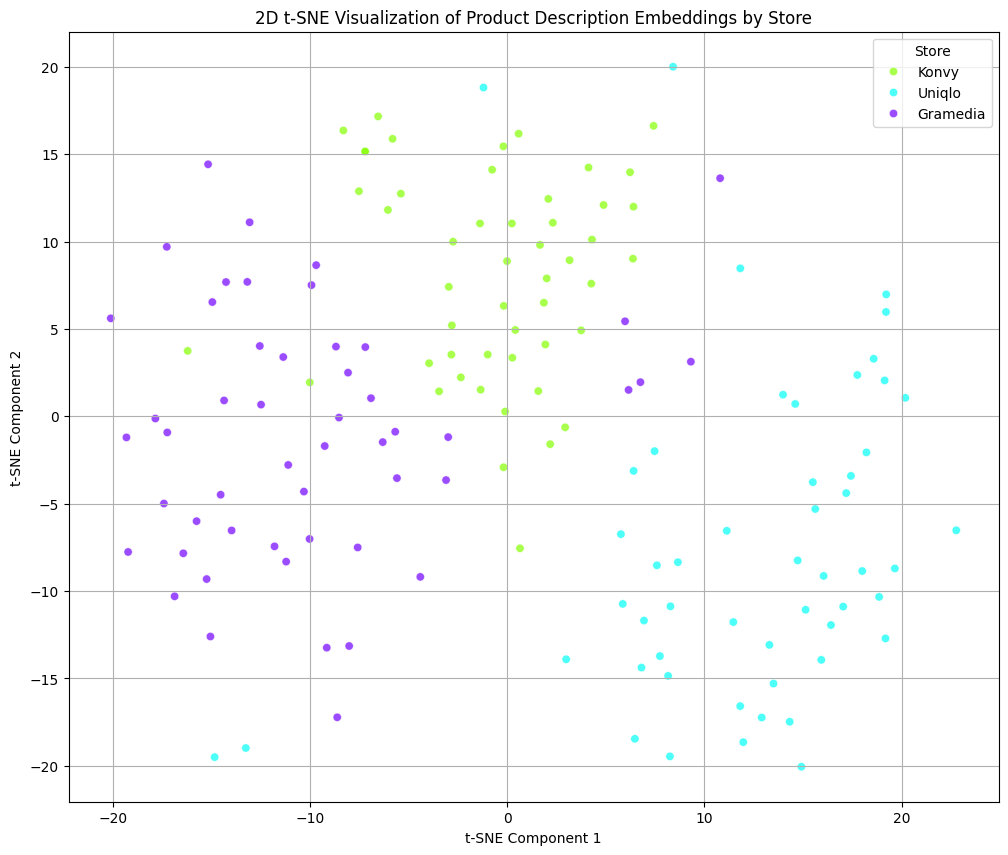

In [24]:
await generate_and_visualize_embeddings(input_df=generated_df)